<a href="https://colab.research.google.com/github/alonsosilvaallende/Survival_Analysis/blob/master/Cox_PH_vs_Gradient_Boosting_Cox_PH_a_practical_guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Survival Analysis: Cox Proportional Hazards vs Gradient Boosting Cox

[Alonso Silva](http://www.dim.uchile.cl/~alsilva/) [(@alonsosilva)](https://twitter.com/alonsosilva) | 2019/09/09



The objective of this notebook is to compare two methods (Cox proportional hazards and gradient boosting Cox PH) to estimate the survival probability given a set of features/covariables.

We install [scikit-survival](https://pypi.org/project/scikit-survival/) and [lifelines](https://lifelines.readthedocs.io/en/latest/).

In [0]:
# install scikit-survival
!pip install scikit-survival

     |████████████████████████████████| 2.3MB 2.8MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.10-cp36-cp36m-linux_x86_64.whl size=2099462 sha256=87767e7a63a5638992700b49e933ed5be28c15f8450c16211d69c0af46e604c7
  Stored in directory: /root/.cache/pip/wheels/6a/71/ec/cc82030060916e31495baef4e77d72386093a4e52532636c90
Successfully built scikit-survival


In [0]:
# install lifelines
!pip install lifelines

     |████████████████████████████████| 337kB 2.8MB/s 


In [0]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## An example: German Breast Cancer Study Group 2 (gbcsg)

This dataset contains the following 8 input variables (features/covariables):

- age (in years), 
- estrogen receptor (in fmol), 
- hormonal therapy (yes or no), 
- menopausal status (premenopausal or postmenopausal),
- number of positive nodes, 
- progesterone receptor (in fmol), 
- tumor grade (I < II < III), 
- tumor size (in mm).


The dataset has 686 samples and 8 features. Recurrence-free survival occurred for 299 patients (43.6%).


**References**

M. Schumacher, G. Basert, H. Bojar, K. Huebner, M. Olschewski, W. Sauerbrei, C. Schmoor, C. Beyerle, R.L.A. Neumann and H.F. Rauschecker for the German Breast Cancer Study Group (1994), [Randomized 2 x 2 trial evaluating hormonal treatment and the duration of chemotherapy in node-positive breast cancer patients](https://www.ncbi.nlm.nih.gov/pubmed/7931478). Journal of Clinical Oncology, 12, 2086–2093.


In [0]:
# download the dataset
from sksurv.datasets import load_gbsg2

X, y = load_gbsg2()

In [0]:
# number of samples, number of features
X.shape

(686, 8)

In [0]:
X.head()

,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize
0,70.0,66.0,no,Post,3.0,48.0,II,21.0
1,56.0,77.0,yes,Post,7.0,61.0,II,12.0
2,58.0,271.0,yes,Post,9.0,52.0,II,35.0
3,59.0,29.0,yes,Post,4.0,60.0,II,17.0
4,73.0,65.0,no,Post,1.0,26.0,II,35.0


In [0]:
y[:5]

array([( True, 1814.), ( True, 2018.), ( True,  712.), ( True, 1807.),
       ( True,  772.)], dtype=[('cens', '?'), ('time', '<f8')])

In [0]:
# function to transform y (a numpy nd array) to a dataframe
def target2df(y):
  censored = [y[i][0] for i in range(len(y))]
  time_to_event = [y[i][1] for i in range(len(y))]
  df_y = pd.DataFrame(data={'censored': censored, 'time': time_to_event})
  return df_y

In [0]:
df_y = target2df(y)
df_y.head(10)

,censored,time
0,True,1814.0
1,True,2018.0
2,True,712.0
3,True,1807.0
4,True,772.0
5,True,448.0
6,False,2172.0
7,False,2161.0
8,True,471.0
9,False,2014.0


One of the main challenges of survival analysis is **right censoring**, i.e., by the end of the study, the event of interest (for example, in medicine 'death of a patient' or in this dataset 'recurrence of cancer') has only occurred for a subset of the observations.

The right censoring in this dataset is given by the column name 'censored' and it's a variable which can take value 'True' if the patient is recurrence free (no recurrence of cancer is observed) or 'False' if the patient had a recurrence of cancer.

In [0]:
len(df_y.query('censored == True')), len(df_y.query('censored == False'))

(299, 387)

There are 299 patients who were recurrence free 

In [0]:
from sksurv.preprocessing import OneHotEncoder

X_num = OneHotEncoder().fit_transform(X)
X_num.head()

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tgrade=II,tgrade=III,tsize
0,70.0,66.0,0.0,1.0,3.0,48.0,1.0,0.0,21.0
1,56.0,77.0,1.0,1.0,7.0,61.0,1.0,0.0,12.0
2,58.0,271.0,1.0,1.0,9.0,52.0,1.0,0.0,35.0
3,59.0,29.0,1.0,1.0,4.0,60.0,1.0,0.0,17.0
4,73.0,65.0,0.0,1.0,1.0,26.0,1.0,0.0,35.0


Split the dataset into training and validation datasets.

In [0]:
from sklearn.model_selection import train_test_split

X_trn, X_val, y_trn, y_val = train_test_split(X_num, y, test_size=0.2, random_state=0)

In [0]:
len(y_trn), len(y_val)

(548, 138)

If we didn't have the features, we could obtain a median time to event (recurrence).

In [0]:
df_y_trn = target2df(y_trn)

In [0]:
df_y_trn.head()

,censored,time
0,False,733.0
1,False,1401.0
2,False,1863.0
3,False,1499.0
4,True,1493.0


In [0]:
df_y_trn['event'] = df_y_trn['censored'].apply(lambda x: not x)

In [0]:
df_y_trn.head()

,censored,time,event
0,False,733.0,True
1,False,1401.0,True
2,False,1863.0,True
3,False,1499.0,True
4,True,1493.0,False


In [0]:
T = df_y_trn['time']
E = df_y_trn['event']

In [0]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(T,E)

<lifelines.KaplanMeierFitter: fitted with 548 observations, 235 censored>

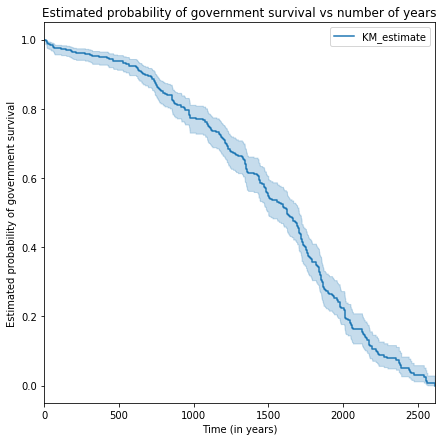

In [0]:
plt.figure(figsize=(7,7))
ax = plt.subplot(111)
kmf.plot(ax=ax)
plt.title('Estimated probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

In [0]:
kmf.median_

1625.0

In [0]:
len(df_y_trn.query('event==True and time < 1625.0')), len(df_y_trn.query('event==True and time > 1625.0'))

(186, 126)

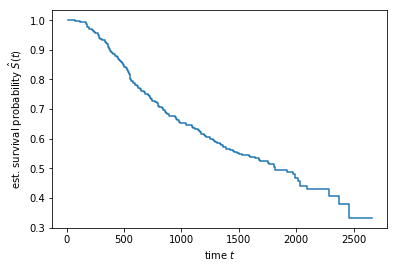

In [0]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(y_trn["cens"], y_trn["time"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. survival probability $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()

In [0]:
S_df = pd.DataFrame(data={'time': time, 'survival_probability' : survival_prob})
S_df[S_df['survival_probability']<0.5].iloc[0]

time                    1814.000000
survival_probability       0.495788
Name: 385, dtype: float64

The estimated median time to event is 1814 days (approximately 5 years).

In [0]:
df_y_trn = target2df(y_trn)
len(df_y_trn.query('censored==False and time < 1814.0')), len(df_y_trn.query('censored==False and time > 1814.0'))

(220, 92)

In [0]:
df_y_val = target2df(y_val)
df_y_val.head()

,censored,time
0,False,1192.0
1,False,1182.0
2,False,1818.0
3,False,1767.0
4,True,1493.0


In [0]:
len(df_y_val.query('censored==False and time < 1814.0')), len(df_y_val.query('censored==False and time > 1814.0'))

(54, 21)

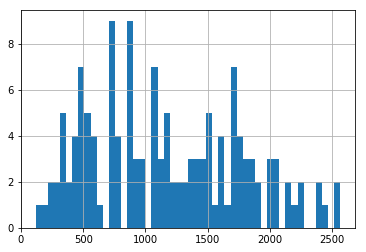

In [0]:
df_y_val['time'].hist(bins=50);

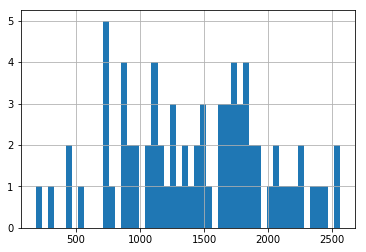

In [0]:
df_y_val[df_y_val['censored']==False]['time'].hist(bins=50);

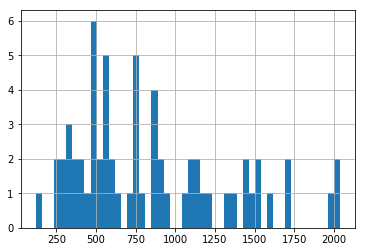

In [0]:
df_y_val[df_y_val['censored']==True]['time'].hist(bins=50);

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

steps = [('scaler', StandardScaler()), ('coxph', CoxPHSurvivalAnalysis())]
cox = Pipeline(steps)
cox.fit(X_trn, y_trn)
ci_cox = concordance_index_censored(y_val["cens"], y_val["time"], cox.predict(X_val))
print(f'The c-index of Cox is given by {ci_cox[0]:.3f}')
print(f'The score of Cox is given by {cox.score(X_val,y_val):.3f}')

The c-index of Cox is given by 0.699
The score of Cox is given by 0.699


In [0]:
pd.Series(cox.named_steps['coxph'].coef_, index=X_num.columns)

age             -0.142127
estrec           0.055462
horTh=yes       -0.174517
menostat=Post    0.176689
pnodes           0.272138
progrec         -0.451793
tgrade=II        0.256260
tgrade=III       0.291318
tsize            0.117181
dtype: float64

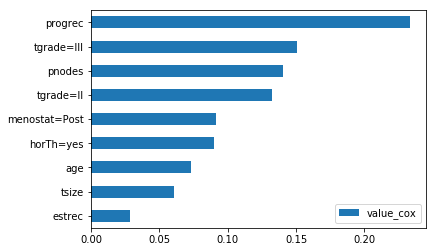

In [0]:
# Feature importance
fi_cox = cox.named_steps['coxph'].coef_
rfi_cox = np.abs(fi_cox)/np.sum(np.abs(fi_cox))
lab = X_num.columns
df_fi_cox = pd.DataFrame({'lab_cox': lab, 'value_cox': rfi_cox}, index=lab)
df_fi_cox = df_fi_cox.sort_values(by='value_cox', ascending=True)
df_fi_cox.plot.barh(y='value_cox');

The progesterone receptor seems to be the most important feature according to Cox proportional hazards, then the tumor grades and the quantity of nodes (pnodes).

In [0]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

gb = GradientBoostingSurvivalAnalysis()
gb.fit(X_trn, y_trn)
ci_gb = concordance_index_censored(y_val["cens"], y_val["time"], gb.predict(X_val))[0]
print(f'The c-index of Gradient Boosting is given by {ci_gb:.3f}')

The c-index of Gradient Boosting is given by 0.693


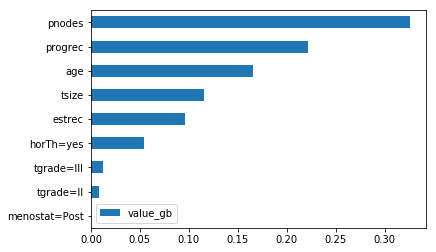

In [0]:
# Feature importance
fi_gb = gb.feature_importances_
rfi_gb =  np.abs(fi_gb)/np.sum(np.abs(fi_gb))
lab = X_num.columns
df_fi_gb = pd.DataFrame({'lab_gb': lab, 'value_gb': rfi_gb}, index=lab)
df_fi_gb = df_fi_gb.sort_values(by='value_gb', ascending=True)
df_fi_gb.plot.barh(y='value_gb');

The number of nodes, the progesterone receptor, and age seem to be the most importan features for Gradient Boosting Cox, while tumor grade seems to be less important especially comparing with the importance it was given by Cox PH.

In [0]:
np.random.seed(0)
seeds = np.random.permutation(1000)[:25]

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

cox_scores = []
gb_scores = []
for seed in seeds:
  X_trn, X_val, y_trn, y_val = train_test_split(X_num, y, test_size=0.2, random_state=seed)
  
  cox = make_pipeline(StandardScaler(), CoxPHSurvivalAnalysis())
  cox.fit(X_trn, y_trn)
  cox_scores.append(cox.score(X_val, y_val))
  
  gb = GradientBoostingSurvivalAnalysis(random_state=seed)
  gb.fit(X_trn, y_trn)
  gb_scores.append(gb.score(X_val, y_val))  

In [0]:
np.mean(cox_scores), np.mean(gb_scores)

(0.673109771300044, 0.6926280275633505)

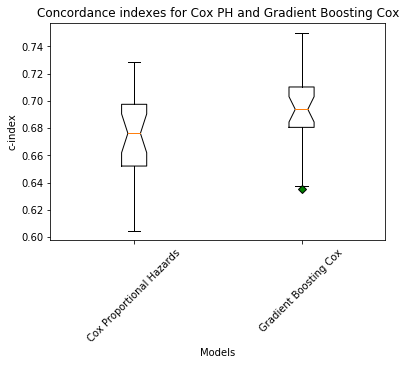

In [0]:
data = [cox_scores, gb_scores]
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Concordance indexes for Cox PH and Gradient Boosting Cox')
ax1.boxplot(data, notch=True, flierprops=green_diamond)
ax1.set_xticklabels(['Cox Proportional Hazards', 'Gradient Boosting Cox'], rotation=45)
ax1.set_xlabel('Models')
ax1.set_ylabel('c-index')
plt.show()